# Analisis Network pada Rosenfeld crime network

Proyek ini bertujuan untuk menganalisis struktur dan karakteristik sebuah jaringan asosiasi antara tersangka, korban, dan/atau saksi yang terlibat dalam kejahatan di St. Louis pada tahun 1990-an. Data diperoleh dari catatan kepolisian melalui metode snowball sampling berdasarkan lima kasus pembunuhan awal. Node merepresentasikan individu dan peristiwa kriminal, dengan garis penghubung (edge) yang menghubungkan individu ke peristiwa kriminal tertentu.

In [1]:
!tar xvjf download.tsv.moreno_crime.tar.bz2

moreno_crime/
moreno_crime/meta.moreno_crime_crime
moreno_crime/README.moreno_crime
moreno_crime/rel.moreno_crime_crime.person.role
moreno_crime/ent.moreno_crime_crime.person.sex
moreno_crime/ent.moreno_crime_crime.person.name
moreno_crime/out.moreno_crime_crime


In [2]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.7 MB/s eta 0:00:00


### Import Library dan Memuat Graf Jaringan Kriminal

Pada bagian ini, kita akan mengimpor library yang dibutuhkan, mendefinisikan fungsi untuk memuat graf jaringan kriminal.


In [3]:
from pyvis.network import Network
import networkx as nx
from os import path as osp
import pandas as pd

# Load graph function
def load_crime_network():
    df = pd.read_csv(
        "moreno_crime/out.moreno_crime_crime",
        sep=" ",
        skiprows=2,
        header=None,
    )
    df = df[[0, 1]]
    df.columns = ["personID", "crimeID"]
    df.index += 1

    # Read in the role metadata
    roles = pd.read_csv(
        "moreno_crime/rel.moreno_crime_crime.person.role",
        header=None,
    )
    roles.columns = ["roles"]
    roles.index += 1

    # Add the edge data to the graph.
    G = nx.Graph()
    for r, d in df.join(roles).iterrows():
        pid = f"p{d['personID']}"  # pid stands for "Person I.D."
        cid = f"c{d['crimeID']}"  # cid stands for "Crime I.D."
        G.add_node(pid, bipartite="person")
        G.add_node(cid, bipartite="crime")
        G.add_edge(pid, cid, role=d["roles"])

    # Read in the gender metadata
    gender = pd.read_csv(
        "moreno_crime/ent.moreno_crime_crime.person.sex",
        header=None,
    )
    gender.index += 1
    for n, gender_code in gender.iterrows():
        nodeid = f"p{n}"
        G.nodes[nodeid]["gender"] = gender_code[0]

    return G

# Load the network
G = load_crime_network()
# Print basic graph information
print("Informasi Graf:")
print(f"- Jumlah node: {G.number_of_nodes()}")
print(f"- Jumlah edge: {G.number_of_edges()}")

# Print the number of nodes by type (bipartite)
person_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") == "person"]
crime_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") == "crime"]

print("\nJumlah Node berdasarkan Jenis:")
print(f"- Node person: {len(person_nodes)}")
print(f"- Node crime: {len(crime_nodes)}")

# Print gender distribution of person nodes
gender_distribution = {}
for node in person_nodes:
    gender = G.nodes[node].get("gender", "Unknown")
    gender_distribution[gender] = gender_distribution.get(gender, 0) + 1

print("\nDistribusi Gender pada Node Person:")
for gender, count in gender_distribution.items():
    print(f"- {gender}: {count}")

# Print the role distribution
role_distribution = {}
for _, _, data in G.edges(data=True):
    role = data.get("role", "Unknown")
    role_distribution[role] = role_distribution.get(role, 0) + 1

print("\nDistribusi Peran pada Edge:")
for role, count in role_distribution.items():
    print(f"- {role}: {count}")


Informasi Graf:
- Jumlah node: 1380
- Jumlah edge: 1476

Jumlah Node berdasarkan Jenis:
- Node person: 829
- Node crime: 551

Distribusi Gender pada Node Person:
- 1: 558
- 0: 271

Distribusi Peran pada Edge:
- Suspect: 682
- Victim: 558
- Witness: 195
- Victim Suspect: 41


**Distribusi Gender**
* 1: Pria
* 0: Wanita

**Distribusi Peran**

* Suspect merujuk pada individu yang dicurigai atau dituduh melakukan tindakan kriminal. Dalam konteks graph ini, peran "Suspect" menandakan bahwa node tersebut (misalnya, seorang pria atau wanita) terlibat langsung sebagai pelaku atau yang dicurigai melakukan tindakan kriminal tertentu.

* Victim merujuk pada individu yang menjadi korban dari tindak kriminal. Peran ini menunjukkan bahwa node tersebut mengalami kerugian atau penderitaan akibat tindakan kriminal yang dilakukan oleh orang lain. Dalam hal ini, wanita kemungkinan besar akan lebih banyak terlibat sebagai korban, berdasarkan asumsi yang disebutkan.

* Witness adalah individu yang menyaksikan atau mengetahui suatu kejadian kriminal tanpa terlibat langsung sebagai pelaku atau korban. Mereka mungkin memberikan kesaksian yang dapat membantu penyelidikan lebih lanjut, tetapi mereka tidak terlibat langsung dalam tindak kriminal.

* Victim Suspect adalah individu yang dapat berperan ganda, baik sebagai korban maupun sebagai tersangka dalam suatu kejadian kriminal. Ini menunjukkan situasi di mana seseorang yang awalnya terlihat sebagai korban mungkin juga dicurigai terlibat dalam tindakan kriminal, misalnya karena adanya faktor-faktor yang belum terungkap atau alasan tertentu yang mengarah pada kecurigaan.

### Membuat Visualisasi Jaringan dengan Pyvis

Pada bagian ini, kita akan menggunakan Pyvis untuk memvisualisasikan jaringan kriminal. Visualisasi ini melibatkan konfigurasi warna dan ukuran simpul berdasarkan tipe dan derajatnya, serta menambahkan opsi interaksi seperti zoom dan navigasi subgraf.

In [ ]:
# Create a Pyvis network
net = Network(height="800px", width="100%", notebook=True, directed=False)

# Calculate node degree
node_degrees = dict(G.degree())

# Define node colors based on their type
for node, data in G.nodes(data=True):
    size = 10  # Default node size
    if node_degrees[node] > 5:  # Threshold for "high degree" nodes
        size *= 2  # Make the node size twice as large

    if data.get("bipartite") == "person":
        color = "blue" if data.get("gender") == 0 else "red"
        net.add_node(node, title=node, color=color, label=node, size=size)
    else:  # crime nodes
        net.add_node(node, title=node, color="green", label=node, size=size)

# Add edges
for source, target, data in G.edges(data=True):
    net.add_edge(source, target, title=f"Role: {data['role']}")

# Configure options for smooth zoom and subgraph navigation
net.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -8000,
      "centralGravity": 0.3,
      "springLength": 95,
      "springConstant": 0.04,
      "damping": 0.09,
      "avoidOverlap": 1
    },
    "solver": "barnesHut"
  },
  "interaction": {
    "navigationButtons": true,
    "keyboard": true,
    "hover": true,
    "zoomView": true
  }
}
""")

# Generate and show the network
net.show("crime_network.html")


crime_network.html


#### Penjelasan Visualisasi Jaringan dengan Pyvis

##### Warna Node:
- **Biru**: Digunakan untuk node bertipe "person" dengan gender bernilai 0 (asumsi: pria).
- **Merah**: Digunakan untuk node bertipe "person" dengan gender bernilai 1 (asumsi: wanita).
- **Hijau**: Digunakan untuk node bertipe "crime".

##### Fungsi Interaksi:
- **Zoom**: Pengguna dapat memperbesar atau memperkecil tampilan jaringan.
- **Navigasi Tombol**: Tombol navigasi ditampilkan untuk membantu eksplorasi jaringan.
- **Navigasi Keyboard**: Pengguna dapat menggunakan keyboard untuk bernavigasi di dalam jaringan.
- **Hover**: Informasi tambahan akan muncul ketika kursor diarahkan ke simpul atau sisi tertentu.


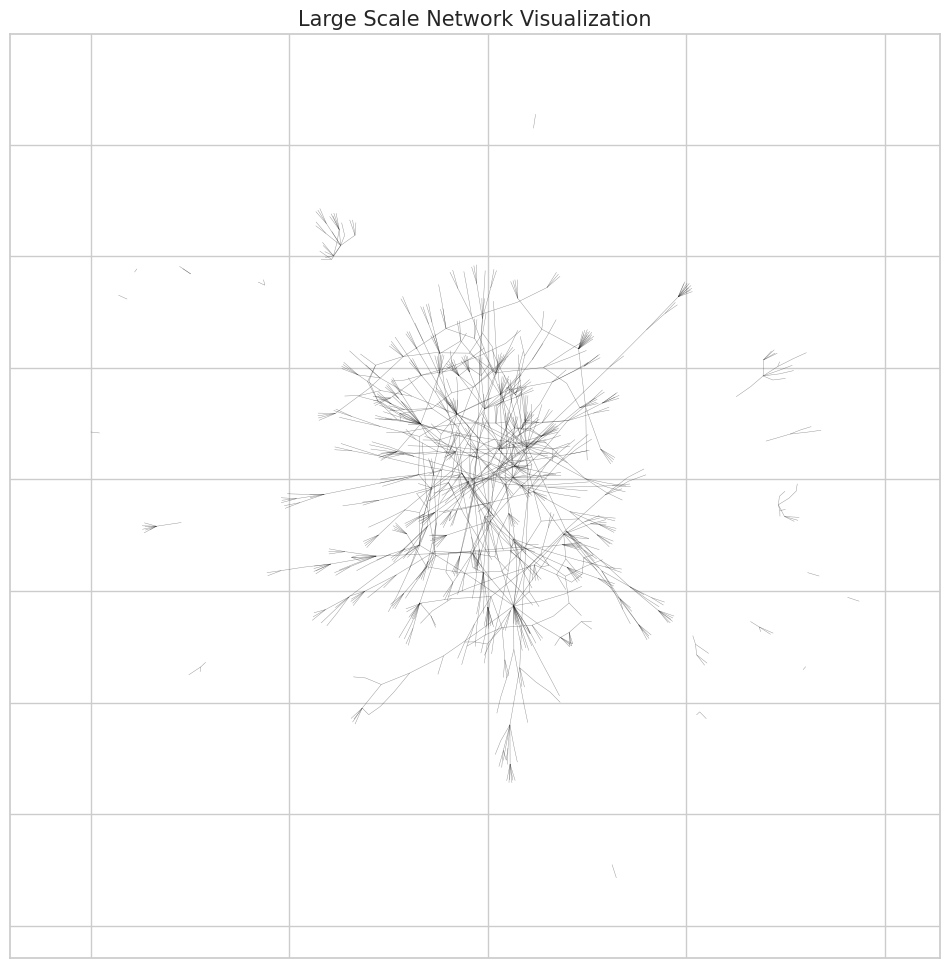

In [ ]:
import matplotlib.pyplot as plt

# Visualisasi network skala besar
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Menggunakan layout Spring
nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.3)
plt.title("Large Scale Network Visualization", fontsize=15)
plt.show()


### Analisis Centrality pada Jaringan

Pada bagian ini, kita akan menghitung berbagai metrik **centrality** untuk graf `G`. Centrality digunakan untuk mengukur pentingnya simpul dalam sebuah jaringan berdasarkan berbagai perspektif.


In [ ]:
import networkx as nx

# Degree Centrality
degree_centrality = nx.degree_centrality(G)

# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)

# Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G)

# PageRank
pagerank = nx.pagerank(G)

#### Fungsi Visualisasi Centrality

In [ ]:
import seaborn as sns

# Set seaborn style for improved aesthetics
sns.set(style="whitegrid")

# Function to create bar plots for top 10 nodes
def plot_top_10(metric_dict, title):
    # Sort and extract top 10 nodes
    top_10 = sorted(metric_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    nodes = [str(node) for node, _ in top_10]
    values = [value for _, value in top_10]

    # Create a barplot
    plt.figure(figsize=(8, 6))
    sns.barplot(x=values, y=nodes, palette="viridis", orient='h')

    # Add titles and labels
    plt.title(f"Top 10 {title}", fontsize=16, fontweight='bold')
    plt.xlabel("Centrality Value", fontsize=14)
    plt.ylabel("Nodes", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()

    # Display the plot
    plt.show()

#### Degree Centrality

Top 10 Degree Centrality:
Node p815: 0.0181
Node p2: 0.0160
Node c110: 0.0131
Node p425: 0.0131
Node p220: 0.0123
Node c153: 0.0109
Node p56: 0.0102
Node c14: 0.0094
Node c43: 0.0094
Node c95: 0.0094


<ipython-input-36-0db2db19f8cc>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values, y=nodes, palette="viridis", orient='h')


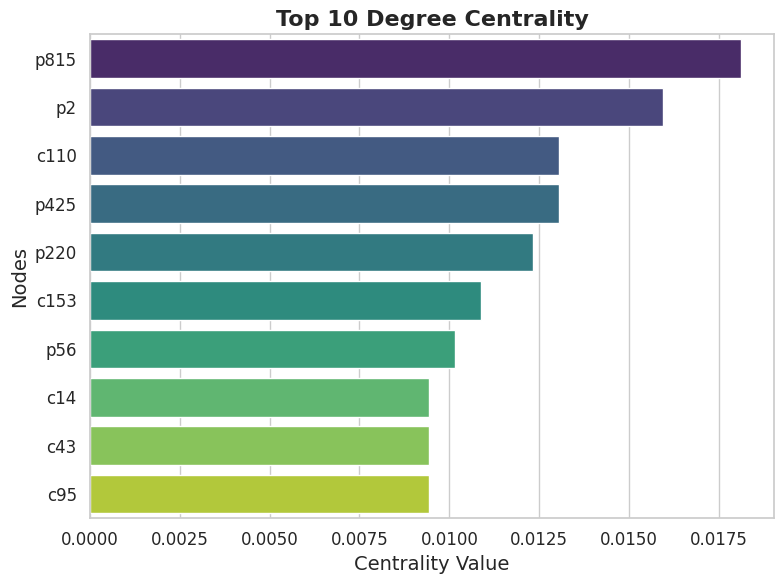

In [ ]:
# Menampilkan Top 10 Degree Centrality
print("Top 10 Degree Centrality:")
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for node, centrality in top_degree:
    print(f"Node {node}: {centrality:.4f}")

plot_top_10(degree_centrality, "Degree Centrality")

Node p815 punya degree centrality tinggi, artinya dia terlibat dalam banyak kasus kejahatan. Bisa jadi dia pelaku yang sering muncul di berbagai kejadian.

Bagaimana Membantu Polisi:
Polisi bisa fokus pada orang yang sering muncul di banyak kejahatan, karena kemungkinan besar dia adalah pelaku utama atau memiliki banyak informasi.

#### Betweenness Centrality


Top 10 Betweenness Centrality:
Node p815: 0.3713
Node c110: 0.3238
Node p690: 0.2542
Node c23: 0.2527
Node c160: 0.2409
Node c47: 0.2186
Node p2: 0.1892
Node c46: 0.1788
Node c14: 0.1686
Node p715: 0.1568


<ipython-input-36-0db2db19f8cc>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values, y=nodes, palette="viridis", orient='h')


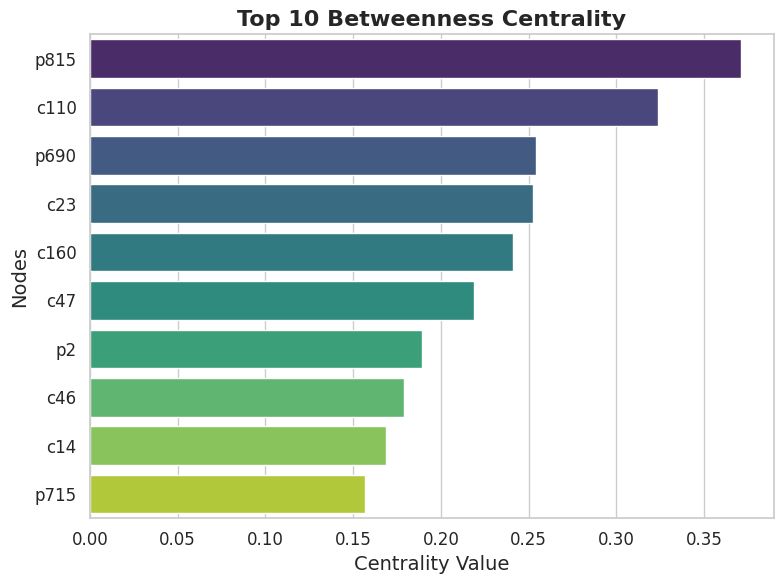

In [ ]:
# Menampilkan Top 10 Betweenness Centrality
print("\nTop 10 Betweenness Centrality:")
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for node, centrality in top_betweenness:
    print(f"Node {node}: {centrality:.4f}")

plot_top_10(betweenness_centrality, "Betweenness Centrality")

Node p815 juga punya betweenness tinggi. Mungkin dia seorang saksi yang menghubungkan banyak kasus berbeda, jadi informasi penting melewati dia.

Bagaimana Membantu Polisi:
Orang ini mungkin bukan pelaku utama, tapi dia tahu banyak karena jadi perantara antar kelompok atau kasus. Polisi bisa menanyakannya untuk menggali informasi.

#### Closeness Centrality


Top 10 Closeness Centrality:
Node c47: 0.1046
Node p690: 0.1043
Node c160: 0.1042
Node p815: 0.1041
Node c23: 0.1041
Node p2: 0.1030
Node p715: 0.1021
Node p356: 0.1017
Node p424: 0.1016
Node c14: 0.1014


<ipython-input-36-0db2db19f8cc>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values, y=nodes, palette="viridis", orient='h')


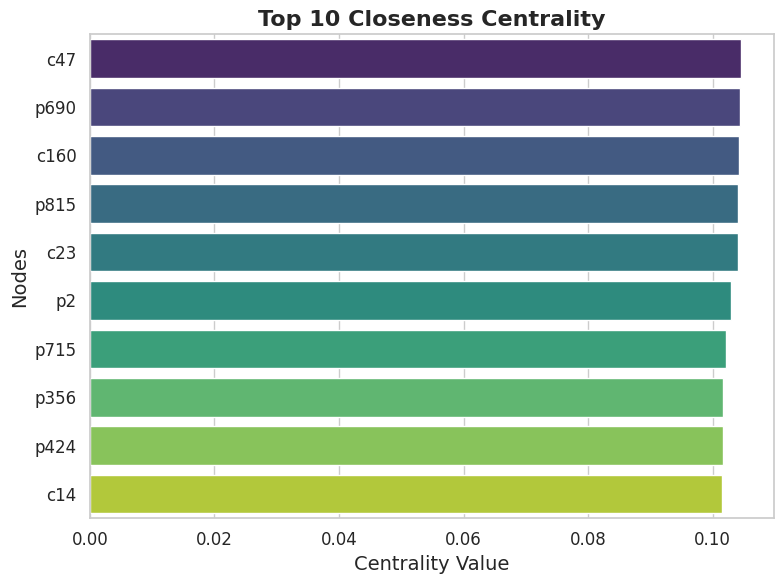

In [ ]:
# Menampilkan Top 10 Closeness Centrality
print("\nTop 10 Closeness Centrality:")
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for node, centrality in top_closeness:
    print(f"Node {node}: {centrality:.4f}")

plot_top_10(closeness_centrality, "Closeness Centrality")

Node c47 punya closeness tinggi, artinya kasus ini menjadi pusat perhatian karena terhubung ke banyak pelaku atau saksi lain dengan cepat.

Bagaimana Membantu Polisi:
Orang ini mungkin adalah koordinator kejahatan, karena dia bisa menghubungi semua anggota dengan mudah. Polisi bisa menargetkan dia untuk memutus komunikasi jaringan.

#### Eigenvector Centrality


Top 10 Eigenvector Centrality:
Node c110: 0.4149
Node p425: 0.4142
Node p715: 0.2477
Node c95: 0.2334
Node p695: 0.2203
Node c417: 0.1834
Node c419: 0.1535
Node c43: 0.1500
Node p413: 0.1424
Node p531: 0.1388


<ipython-input-36-0db2db19f8cc>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values, y=nodes, palette="viridis", orient='h')


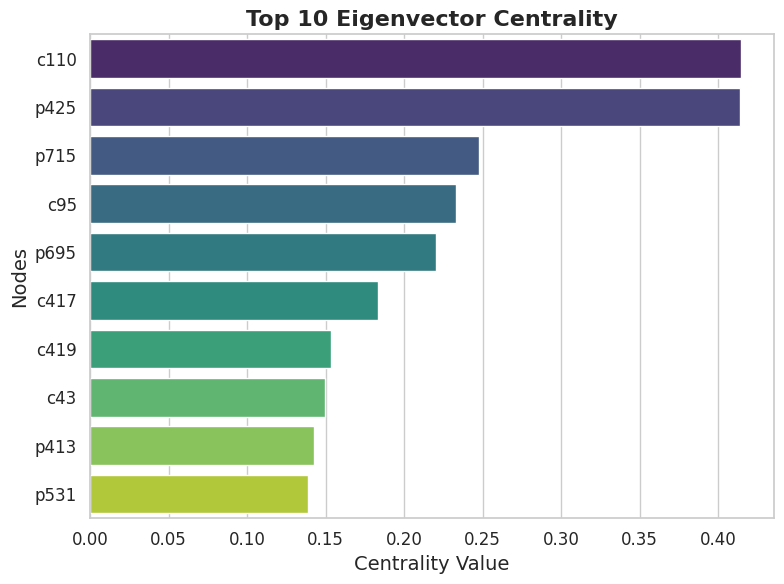

In [ ]:
# Menampilkan Top 10 Eigenvector Centrality
print("\nTop 10 Eigenvector Centrality:")
top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for node, centrality in top_eigenvector:
    print(f"Node {node}: {centrality:.4f}")

plot_top_10(eigenvector_centrality, "Eigenvector Centrality")

Node c110 punya eigenvector tinggi. Mungkin ini adalah kasus besar yang melibatkan orang-orang penting dalam jaringan kejahatan.

Bagaimana Membantu Polisi:
Polisi bisa memprioritaskan orang ini karena dia dekat dengan pelaku-pelaku penting lainnya. Menangkap dia bisa mengungkap banyak informasi.

#### PageRank


Top 10 PageRank:
Node p815: 0.0067
Node p2: 0.0060
Node c153: 0.0050
Node p220: 0.0048
Node p425: 0.0044
Node c110: 0.0043
Node c161: 0.0038
Node p56: 0.0037
Node c43: 0.0036
Node c14: 0.0036


<ipython-input-36-0db2db19f8cc>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values, y=nodes, palette="viridis", orient='h')


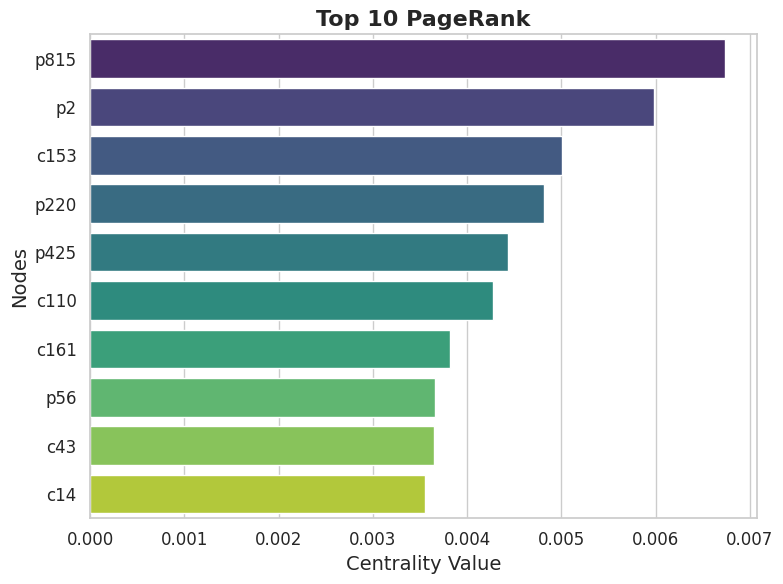

In [ ]:
# Menampilkan Top 10 PageRank
print("\nTop 10 PageRank:")
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
for node, rank in top_pagerank:
    print(f"Node {node}: {rank:.4f}")

plot_top_10(pagerank, "PageRank")

Node p815 punya PageRank tinggi. Mungkin dia bukan pelaku besar, tapi dia tetap penting karena sering terlibat secara langsung atau tidak langsung.

Bagaimana Membantu Polisi:
Polisi bisa menargetkan orang dengan PageRank tinggi karena mereka penting dalam jaringan, meski mungkin terlihat tidak terlalu aktif.

### Average Degree dan Degree Distribution

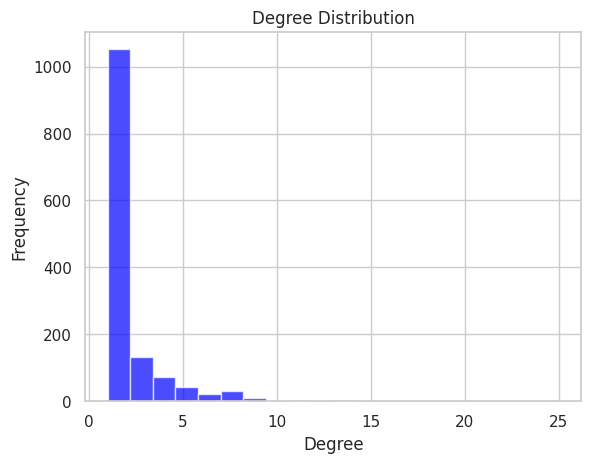

Average Degree: 2.139130434782609


In [ ]:
import matplotlib.pyplot as plt

# Average Degree
average_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()

# Degree Distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
plt.hist(degree_sequence, bins=20, color='blue', alpha=0.7)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

print(f"Average Degree: {average_degree}")


Average degree adalah 2.1. Ini artinya rata-rata orang (pelaku, saksi, korban) hanya terhubung dengan 2 kasus kejahatan.

Bagaimana Membantu Polisi:
Jika rata-rata koneksi rendah, berarti kejahatan dilakukan oleh kelompok kecil atau individu. Jika tinggi, berarti ada geng besar yang perlu dipecah.

### Clustering Coefficient

In [4]:
import networkx as nx

# Calculate clustering coefficient for each node
clustering_coefficients = nx.clustering(G)

# Sort nodes by clustering coefficient in descending order
sorted_clustering_coefficients = sorted(clustering_coefficients.items(), key=lambda item: item[1], reverse=True)

# Print the sorted clustering coefficients
for node, coefficient in sorted_clustering_coefficients:
    print(f"Node {node}: {coefficient}")

Node p1: 0
Node c1: 0
Node c2: 0
Node c3: 0
Node c4: 0
Node p2: 0
Node c5: 0
Node c6: 0
Node c7: 0
Node c8: 0
Node c9: 0
Node c10: 0
Node c11: 0
Node c12: 0
Node c13: 0
Node c14: 0
Node c15: 0
Node c16: 0
Node c17: 0
Node c18: 0
Node c19: 0
Node c20: 0
Node c21: 0
Node c22: 0
Node c23: 0
Node c24: 0
Node c25: 0
Node c26: 0
Node p3: 0
Node c27: 0
Node p4: 0
Node p5: 0
Node p6: 0
Node c28: 0
Node p7: 0
Node c29: 0
Node p8: 0
Node c30: 0
Node p9: 0
Node c31: 0
Node p10: 0
Node c32: 0
Node c33: 0
Node c34: 0
Node c35: 0
Node c36: 0
Node c37: 0
Node c38: 0
Node c39: 0
Node p11: 0
Node p12: 0
Node c40: 0
Node c41: 0
Node c42: 0
Node p13: 0
Node p14: 0
Node p15: 0
Node c43: 0
Node p16: 0
Node c44: 0
Node p17: 0
Node c45: 0
Node c46: 0
Node c47: 0
Node c48: 0
Node c49: 0
Node p18: 0
Node c50: 0
Node p19: 0
Node c51: 0
Node p20: 0
Node p21: 0
Node c52: 0
Node c53: 0
Node p22: 0
Node c54: 0
Node p23: 0
Node c55: 0
Node p24: 0
Node c56: 0
Node p25: 0
Node p26: 0
Node c57: 0
Node p27: 0
Node c58: 

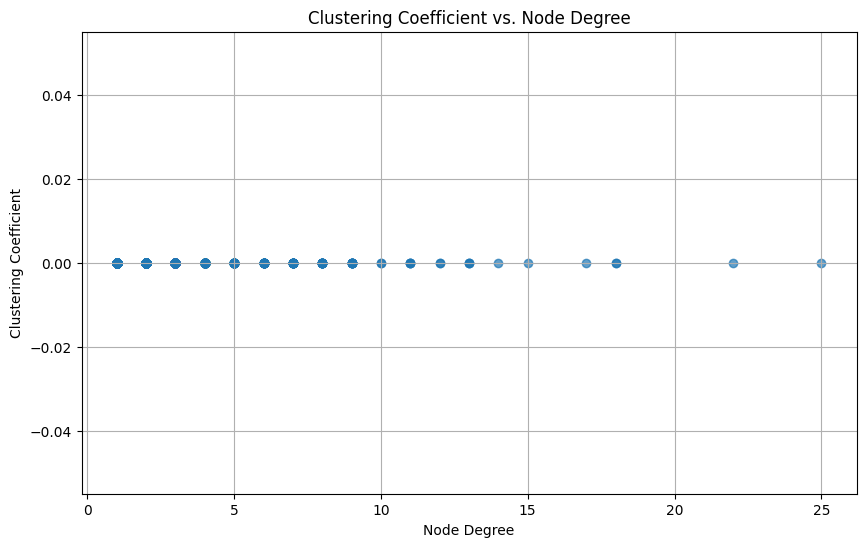

In [6]:
clustering_coefficients = nx.clustering(G)
node_degrees = dict(G.degree())

# Create a list to store node degree and clustering coefficient pairs
degree_clustering_data = []
for node, degree in node_degrees.items():
    degree_clustering_data.append((degree, clustering_coefficients[node]))

# Separate degrees and clustering coefficients
degrees, clustering_coeffs = zip(*degree_clustering_data)


plt.figure(figsize=(10, 6))
plt.scatter(degrees, clustering_coeffs, alpha=0.7)
plt.xlabel("Node Degree")
plt.ylabel("Clustering Coefficient")
plt.title("Clustering Coefficient vs. Node Degree")
plt.grid(True)
plt.show()

In [ ]:
# Average Clustering Coefficient
average_clustering = nx.average_clustering(G)
print(f"Average Clustering Coefficient: {average_clustering:.4f}")


Average Clustering Coefficient: 0.0000


Clustering coefficient 0.000 artinya saksi atau pelaku tidak sering terhubung ke grup kejahatan yang sama, jadi lebih individual. Kejahatan mungkin dilakukan secara individual atau oleh kelompok kecil yang tidak saling kenal. Saksi, pelaku, atau korban tidak memiliki hubungan pribadi yang signifikan dengan orang lain dalam jaringan, selain dari keterlibatan mereka dalam kasus tertentu.

Dalam kasus di jaringan ini, misalkan:
Node p815 (seorang pelaku utama) terhubung dengan saksi c14 dan korban c43. Namun, saksi c14 dan korban c43 tidak saling kenal atau tidak terhubung langsung. Ini menghasilkan clustering coefficient rendah, karena tidak ada hubungan antara tetangga-tetangga dari p815.

Bagaimana Membantu Polisi:
Jika nilai rendah, kejahatan mungkin dilakukan secara individual atau oleh kelompok kecil yang tidak saling kenal.

### Diameter & Average Path Length

In [ ]:
# Get the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc)

# Diameter and Average Path Length
diameter = nx.diameter(G_lcc)
avg_path_length = nx.average_shortest_path_length(G_lcc)
print(f"Diameter: {diameter}")
print(f"Average Path Length: {avg_path_length:.4f}")


Diameter: 32
Average Path Length: 12.9561


Diameter 32 menunjukkan beberapa saksi atau pelaku terhubung melalui rantai panjang perantara, membuat informasi lambat menyebar.

Bagaimana Membantu Polisi:
Jika diameter besar, informasi menyebar lambat, dan polisi bisa memanfaatkan waktu ini untuk menangkap pelaku sebelum mereka saling berkomunikasi.

Dengan nilai Average Path Length 12.96, ini menunjukkan informasi atau koneksi antar kasus kejahatan biasanya memerlukan banyak langkah.

Bagaimana Membantu Polisi:
Jika rata-rata langkah tinggi, jaringan tidak terlalu efisien. Polisi bisa memanfaatkan ini untuk mencegah rencana kejahatan sebelum semua pelaku tahu.

### Scaling Exponent

Scaling Exponent (Slope): 2.43


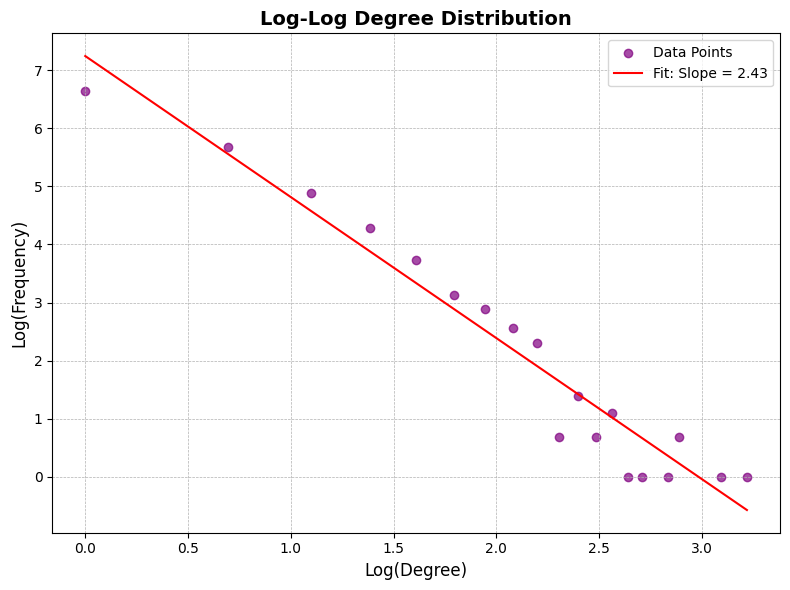

In [21]:
# Log-Log Plot for Degree Distribution
import numpy as np

degree_counts = np.array(nx.degree_histogram(G))
degrees = np.arange(len(degree_counts))
valid = degree_counts > 0

log_degrees = np.log(degrees[valid])
log_counts = np.log(degree_counts[valid])
slope, intercept = np.polyfit(log_degrees, log_counts, 1)

print(f"Scaling Exponent (Slope): {abs(slope):.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(log_degrees, log_counts, color='purple', alpha=0.7, label='Data Points')
plt.plot(log_degrees, slope * log_degrees + intercept, color='red', label=f'Fit: Slope = {abs(slope):.2f}')
plt.title("Log-Log Degree Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Log(Degree)", fontsize=12)
plt.ylabel("Log(Frequency)", fontsize=12)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Dengan slope sekitar 2.43, jaringan ini menunjukkan ketimpangan koneksi yang signifikan. Artinya, hanya sedikit orang yang benar-benar berperan besar dalam jaringan ini, sementara sebagian besar hanya terlibat sedikit.

### Assortativity

In [ ]:
assortativity = nx.degree_assortativity_coefficient(G)
print(f"Assortativity: {assortativity:.4f}")


Assortativity: -0.1660


Nilai -0.166 menunjukkan pelaku terkenal sering terhubung dengan saksi atau korban yang tidak terkenal.

Bagaimana Membantu Polisi:
Jika nilai negatif, polisi tahu pelaku utama sering menggunakan orang kecil atau saksi untuk menjalankan tugas, jadi polisi bisa menargetkan orang kecil untuk mengungkap pelaku besar.

### Modularity

Louvain Community Detection adalah algoritma greedy yang digunakan untuk menemukan struktur komunitas terbaik dalam suatu graf atau jaringan. Tujuannya adalah untuk mengelompokkan node-node yang memiliki koneksi yang lebih kuat satu sama lain ke dalam komunitas yang sama, sementara node-node dengan koneksi yang lebih lemah ditempatkan di komunitas yang berbeda.

Modularity: 0.9297
Number of communities: 49


<ipython-input-11-dec1f6a07c8e>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


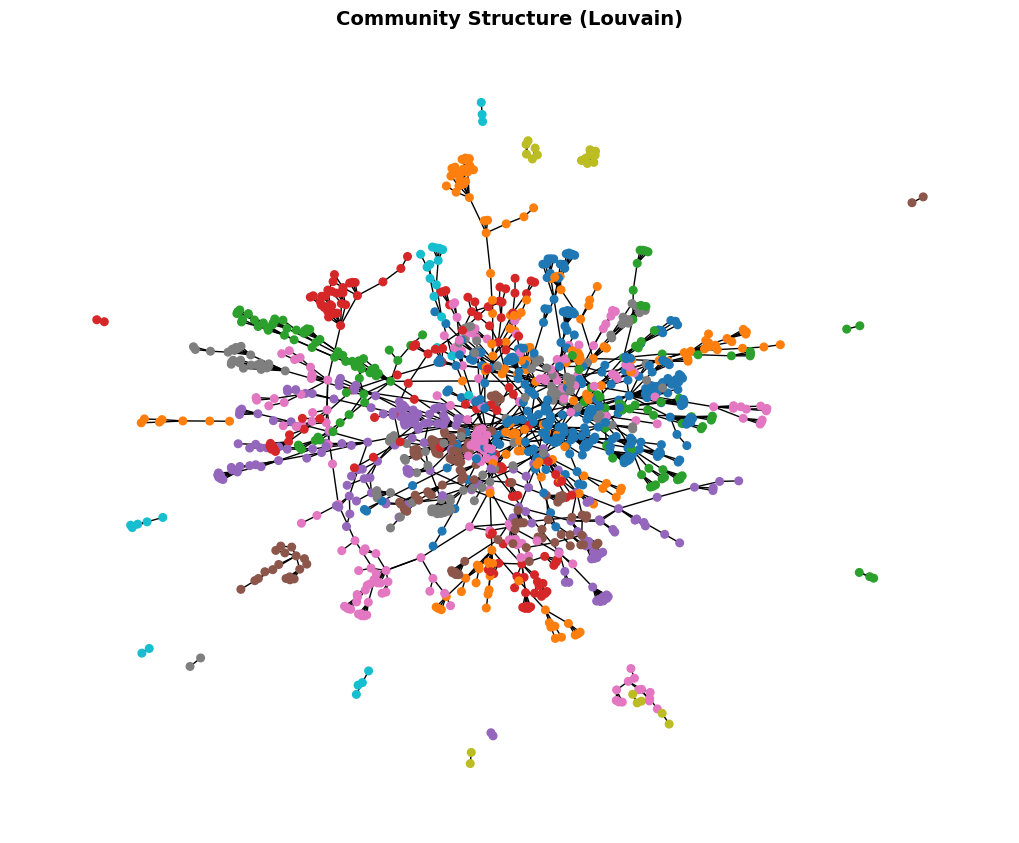

In [11]:
from networkx.algorithms.community import modularity
from community import community_louvain

# Louvain Community Detection
partition = community_louvain.best_partition(G)
modularity_score = modularity(G, [set([node for node in partition if partition[node] == community])
                                  for community in set(partition.values())])
print(f"Modularity: {modularity_score:.4f}")

# Compute the best partition
partition = community_louvain.best_partition(G)
num_communities = len(set(partition.values()))

print(f"Number of communities: {num_communities}")

# Assign colors to each community
colors = [partition[node] for node in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw_spring(
    G, node_color=colors, with_labels=False, node_size=30, cmap=plt.cm.tab10
)
plt.title("Community Structure (Louvain)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Dengan modularity 0.9297, jaringan ini punya kelompok-kelompok kejahatan yang jelas, misalnya geng kejahatan yang bekerja di area tertentu.

Bagaimana Membantu Polisi:
Jika modularity tinggi, polisi bisa memecah jaringan kejahatan dengan menyerang kelompok satu per satu. Setiap kelompok lebih mudah dihancurkan daripada jaringan besar.

### **Kesimpulan:**

Dengan memahami metrik-metrik ini, petugas keamanan bisa mengambil langkah strategis:


*   Menargetkan orang yang paling aktif (degree centrality).
*   Menangkap penghubung penting untuk memutus jaringan (betweenness centrality).
*   Fokus pada koordinator atau pelaku berpengaruh (closeness, eigenvector, PageRank).
*   Menyusun strategi untuk memecah kelompok besar (modularity, clustering).